In [88]:
import time

import numpy as np
import cv2
from imutils import face_utils
import dlib
from face import FacePoints
from tracking import TrackPoints
from tqdm import tqdm
#from tqdm.notebook import tqdm

import matplotlib.pyplot as plt


In [89]:
def draw_str(dst, target, s):
    x, y = target
    cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


In [126]:
capture = cv2.VideoCapture('./data/face_videos/sitting_phone.mp4')
fps = int(capture.get(cv2.CAP_PROP_FPS))
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
print('fps', fps, 'frame count', frame_count)


fps 14 frame count 304


In [127]:
gray_frames = [] #0 is newest -1 is oldest
#frame_c = 0

#face = FacePoints(dedector_type='face_shape')
face = FacePoints(dedector_type='haar')
tracking = TrackPoints(face_dedector=face, max_trace_history=600)

# Create some random colors
color = np.random.randint(0,255,(100,3))

gray = None
vis = None

#while capture.isOpened():
for frame_c in tqdm(range(frame_count)):
    # getting a frame
    ret, frame = capture.read()
    if not ret:
        print('err at', frame_c)
        continue

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    vis = frame.copy()

    gray_frames.insert(0, gray)

    # Wait 5 frames before selecting points
    if frame_c >= 5:
        gray_frames.pop()
        
        tracking.track_points(gray_frames[1], gray_frames[0])

    #frame_c += 1

capture.release()


100%|██████████| 304/304 [00:10<00:00, 29.75it/s]

err at 301
err at 302
err at 303


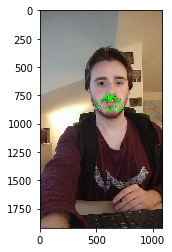

In [128]:
# Plot inline
%matplotlib inline

nextPts = tracking.get_current_points()

# Draw points
for i, new in enumerate(nextPts):
    a,b = new.ravel()
    vis = cv2.circle(vis,(a,b),5,color[i%100].tolist(),-1)

# Draw Tracks
cv2.polylines(vis, [np.int32(tr) for tr in tracking.traces], False, (0, 255, 0))

# The important part - Correct BGR to RGB channel
img = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

# Plot
plt.imshow(img)

# Calculate distance travalled by tracks
#all_tracks = tracking.traces


In [129]:
len(tracking.traces[0])

297

In [130]:
# Filter traces get 4sec or long nyquist freq for 0.5 hz -> 1 hZ
#traces = [trace for trace in tracking.traces if len(trace) > 4*fps]
trace_max_len = max( [len(trace) for trace in tracking.traces] )
#TODO: This is quickfix
traces = [trace for trace in tracking.traces if len(trace) == trace_max_len]

In [131]:
traces[-1]

[(559.0, 782.0),
 (555.77637, 781.9697),
 (539.55835, 791.2778),
 (537.50507, 791.7923),
 (535.3522, 793.41113),
 (534.4322, 793.03796),
 (533.4575, 792.2814),
 (532.03564, 793.09247),
 (531.41565, 793.08484),
 (531.03156, 792.7709),
 (531.21826, 792.4657),
 (531.2852, 793.5555),
 (530.96497, 793.7068),
 (530.97156, 793.46265),
 (530.4378, 794.44196),
 (530.3694, 794.65753),
 (531.60425, 793.74713),
 (531.03143, 793.58813),
 (530.5259, 793.91064),
 (530.256, 792.94244),
 (530.381, 793.37854),
 (530.5737, 793.38153),
 (531.0333, 793.7259),
 (531.3576, 794.7063),
 (532.7169, 795.66046),
 (532.668, 797.1841),
 (532.5632, 796.92706),
 (533.3512, 797.69116),
 (535.4502, 798.0214),
 (535.0566, 799.5879),
 (536.15027, 798.978),
 (535.85706, 799.2554),
 (536.4067, 798.93195),
 (536.67706, 799.45575),
 (536.3373, 799.3213),
 (536.18536, 799.31976),
 (535.5319, 799.6956),
 (535.4592, 800.0633),
 (535.18005, 799.73035),
 (534.6843, 799.2721),
 (535.0466, 797.21277),
 (535.30963, 795.9057),
 (534.

In [132]:
# Calculate y movement of each
displacements = []
#displacements = np.array([[]])
for trace in reversed(traces):
    trace = np.array(trace)

    y_pts = trace[:, 1]
    # Pad array to standart lenght
    len_diff = trace_max_len-len(y_pts)
    if len_diff > 0:
        print('Padded', len_diff)    
    y_pts = np.pad(y_pts, (len_diff, 0), 'edge')
    
    displace = np.diff(y_pts) # y coordinates
    displacements.append(displace)
    #displacements = np.concatenate((displacements, displace), axis=0)
    
#     t = np.arange(len(displace))/fps
#     plt.plot(t, displace)

#     plt.grid()
#     plt.xlabel('Frame')
#     plt.ylabel('Displacement')

#     plt.show()

In [133]:
displacements = np.stack(displacements, axis=0)

## Get FFT and filter



In [134]:
from scipy import interpolate, signal, optimize
from scipy.fftpack import fft, ifft, fftfreq, fftshift

plt.rcParams['figure.figsize'] = [10, 5]

Signal: 0


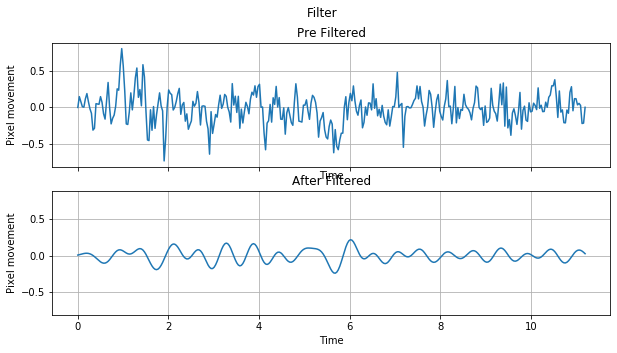

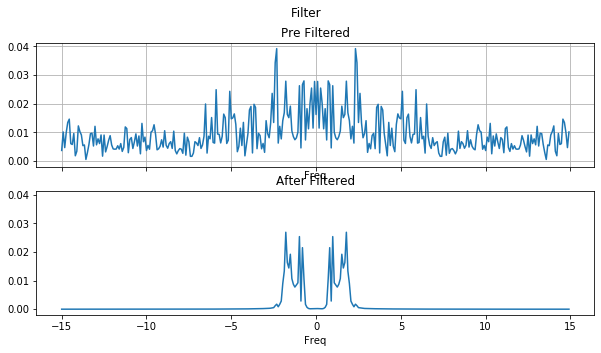

Signal: 1


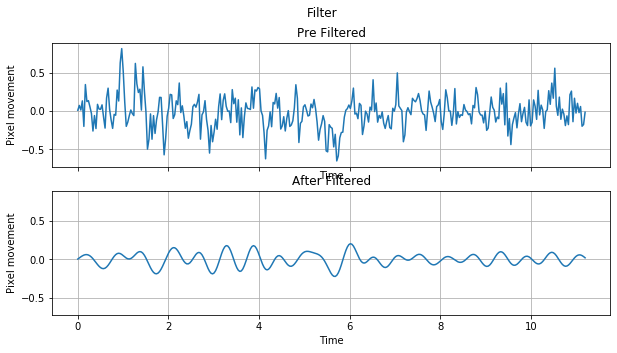

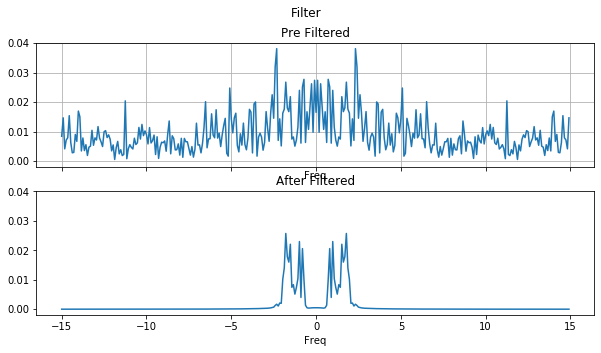

Signal: 2


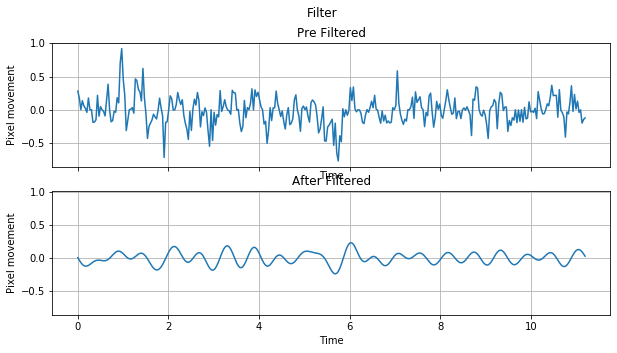

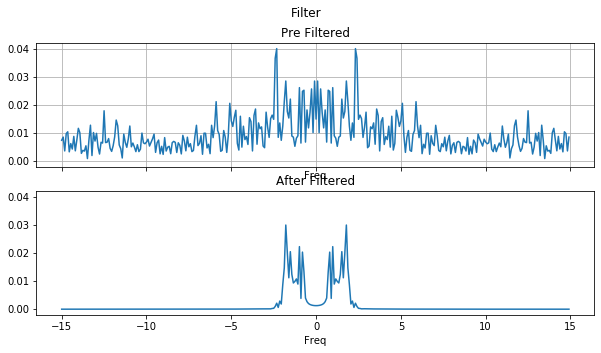

Signal: 3


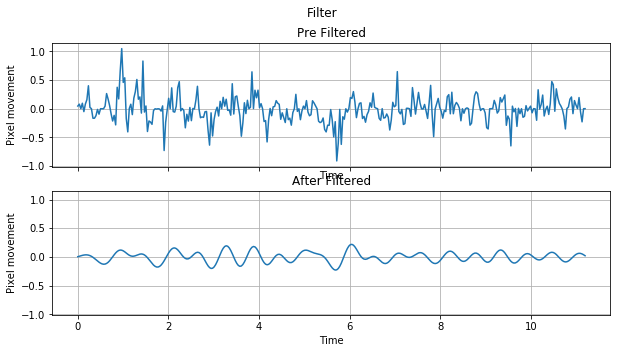

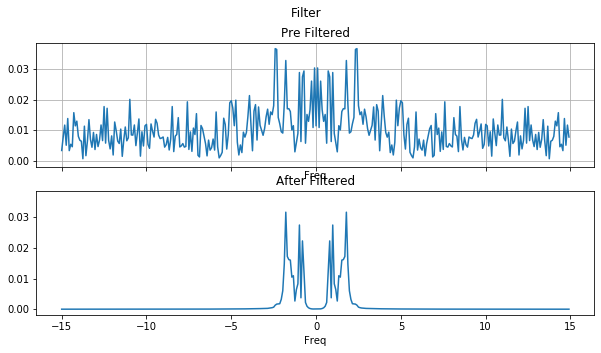

Signal: 4


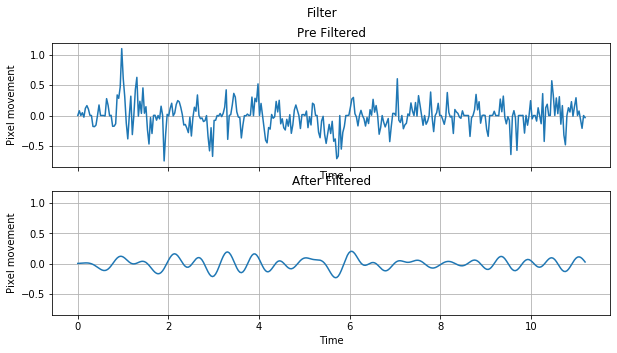

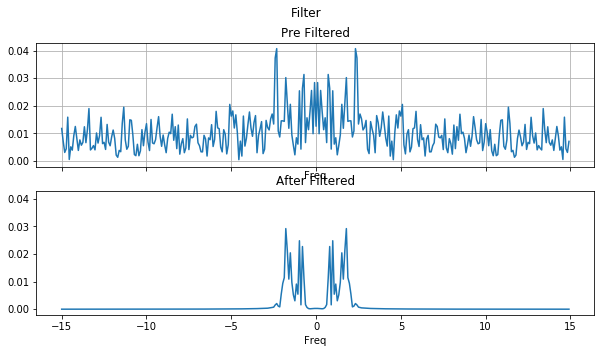

Signal: 5


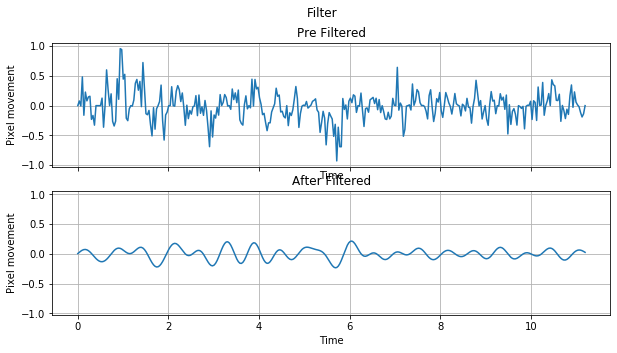

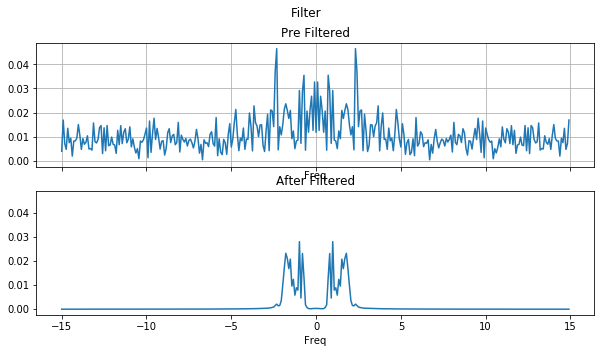

Signal: 6


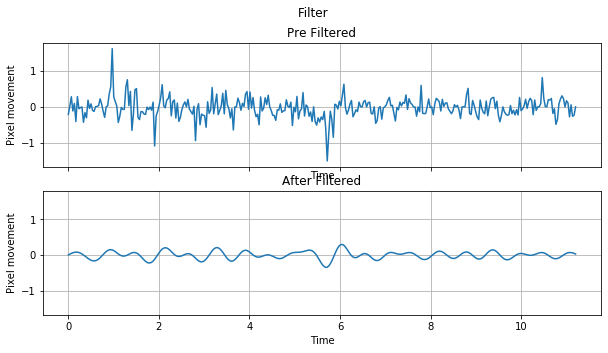

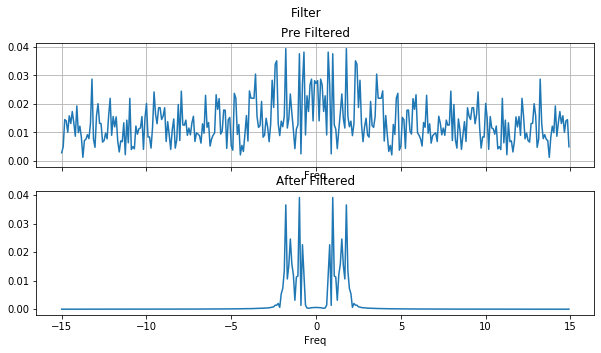

Signal: 7


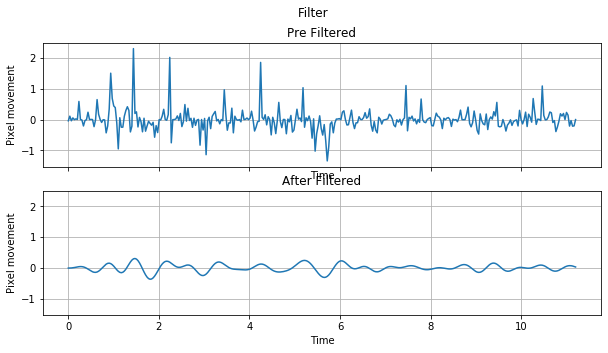

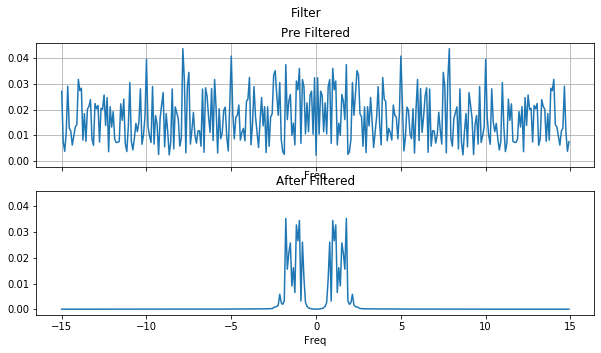

Signal: 8


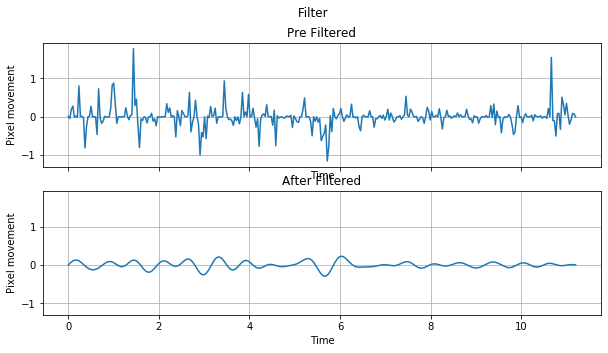

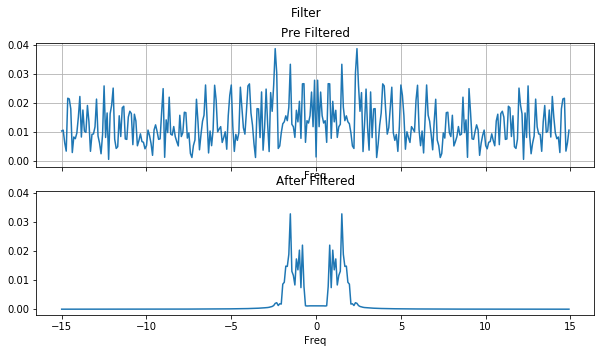

Signal: 9


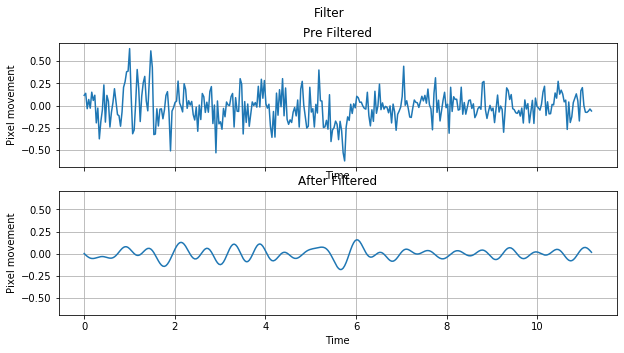

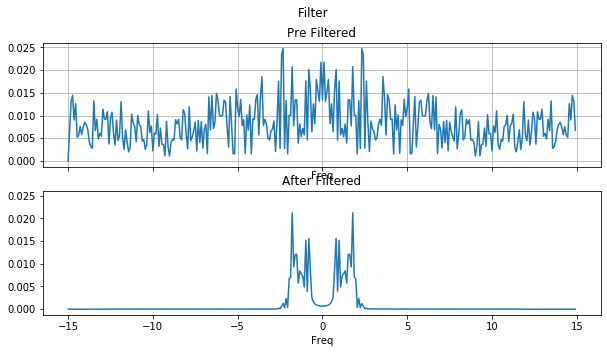

Signal: 10


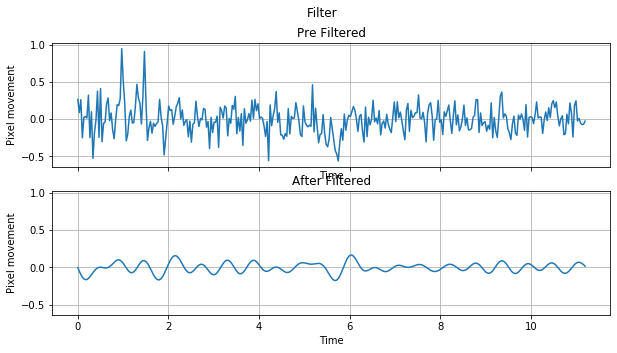

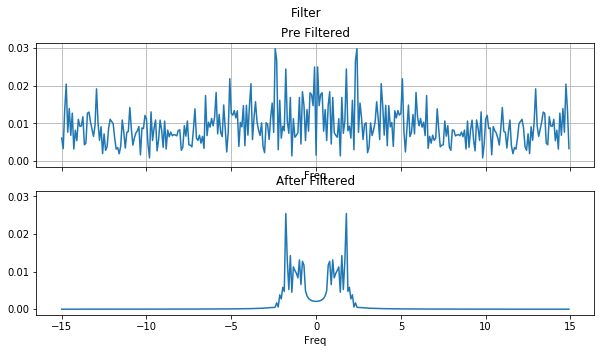

In [12]:
for i, signal_data in enumerate(displacements):
    if i > 10:
        break
    
    #signal_data = displacements[15]
    print('Signal:', i)

    fs = 30 # Fps
    # number of signal points
    N = len(signal_data)
    # sample spacing
    T = 1.0 / fs

    #Draw signal
    #t = np.arange(len(displace))/fps
    t = np.linspace(0.0, T*N, N)


    # Filter signal
    fc = np.array([0.75, 2.])  # Cut-off frequency of the filter
    # 0.75 hz - 2 hz => 45bpm - 120bpm

    w = fc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(5, w, 'bandpass')

    filter_output = signal.filtfilt(b, a, signal_data)


    # Show FFT
    # Draw pre and after FFT

    pre_yf = fft(signal_data)
    pre_xf = fftfreq(N, T)
    pre_xf = fftshift(pre_xf)
    pre_yf = fftshift(pre_yf)

    after_yf = fft(filter_output)
    after_xf = fftfreq(N, T)
    after_xf = fftshift(after_xf)
    after_yf = fftshift(after_yf)

    # Draw
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.suptitle('Filter')

    ax1.plot(t, signal_data)
    ax1.set_title('Pre Filtered')
    ax1.grid()
    ax1.set(xlabel='Time', ylabel='Pixel movement')

    ax2.plot(t, filter_output)
    ax2.set_title('After Filtered')
    ax2.grid()
    ax2.set(xlabel='Time', ylabel='Pixel movement')

    plt.show()

    # Draw
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
    fig.suptitle('Filter')

    ax1.plot(pre_xf, 1.0/N * np.abs(pre_yf))
    ax1.set_title('Pre Filtered')
    ax1.grid()
    ax1.set(xlabel='Freq', ylabel='')

    ax2.plot(after_xf, 1.0/N * np.abs(after_yf))
    ax2.set_title('After Filtered')
    ax2.grid()
    ax2.set(xlabel='Freq', ylabel='')


    plt.grid()
    plt.show()


In [135]:
# Filter Signal
def filter_signal(signal_data, fs=30, low_c=0.75, high_c=2.0):

    #fs = 30 # Fps
    # number of signal points
    N = len(signal_data)
    # sample spacing
    T = 1.0 / fs

    #Draw signal
    #t = np.arange(len(displace))/fps
    t = np.linspace(0.0, T*N, N)

    # Filter signal
    fc = np.array([low_c, high_c])  # Cut-off frequency of the filter
    # 0.75 hz - 2 hz => 45bpm - 120bpm

    w = fc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(5, w, 'bandpass')

    filter_output = signal.filtfilt(b, a, signal_data)
    
    return filter_output

filtered_signals = []

for signal_data in displacements:
    filter_out = filter_signal(signal_data, fs=fps, high_c=3.0)
    filtered_signals.append(filter_out)

filtered_signals = np.stack(filtered_signals, axis=0)

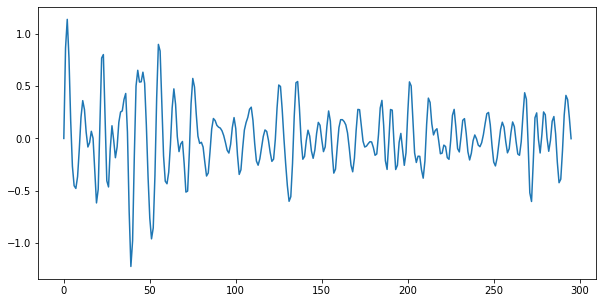

In [136]:
plt.plot(filtered_signals[8])

## DO PCA

In [137]:
from sklearn.decomposition import PCA
filtered_signals.shape

(73, 296)

In [138]:
#filtered_signals

pca = PCA(n_components=5)
pca_result = pca.fit_transform(filtered_signals.T).T
pca_result.shape

(5, 296)

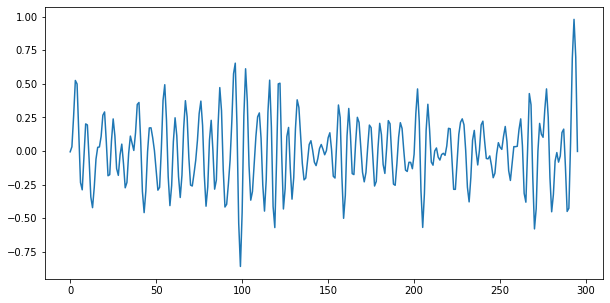

In [139]:
plt.plot(pca_result[4])

In [140]:
#pca_result.explained_variance_ratio_

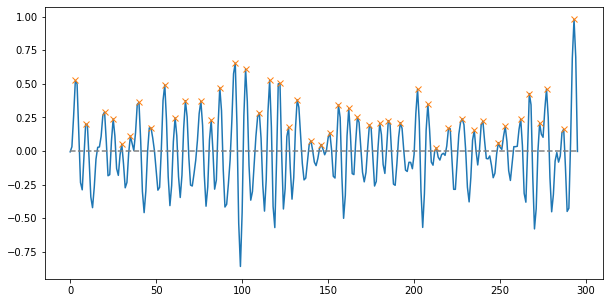

130.54054054054055


In [141]:
from scipy.signal import find_peaks

x = pca_result[4]
peaks, _ = find_peaks(x, height=0)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

total_secs = len(x)/fps
total_beats = len(peaks)
bps = total_beats / total_secs

print(bps*60)

In [154]:
def get_results(signal, fs=30, draw=False):
    
    # number of signal points
    N = len(signal_data)
    # sample spacing
    T = 1.0 / fs
    

    # Get fft
    spectrum = np.abs(fft(signal_data))
    spectrum *= spectrum
    xf = fftfreq(N, T)

    # Get maximum ffts index from second half
    #maxInd = np.argmax(spectrum[:int(len(spectrum)/2)+1])
    maxInd = np.argmax(spectrum)
    maxFreqPow = spectrum[maxInd]
    maxFreq = np.abs(xf[maxInd])

    total_power = np.sum(spectrum)
    # Get max frequencies power percentage in total power
    percentage = maxFreqPow / total_power
    
    bpm = maxFreq * 60
    
    if draw:
        t = np.linspace(0.0, T*N, N)
        fig, (ax1, ax2) = plt.subplots(2, 1)

        ax1.set_title('Signal data')
        ax1.plot(t, signal_data)
        #ax1.plot(peaks/fps, signal_data[peaks], "x")
        #ax1.plot(np.zeros_like(t/fps), "--", color="gray")
        ax1.set(xlabel='Time', ylabel='Pixel movement')
        ax1.grid()

        ax2.plot(xf, 1.0/N * spectrum)
        ax2.set_title('FFT')
        ax2.axvline(maxFreq, color='red')
        ax2.grid()
        ax2.set(xlabel='Freq', ylabel='')
        
        

        print("Max power Freq {} % {} BPM:{}".format(maxFreq, percentage, bpm))

    return maxFreq, percentage
        

BPM 79.45945945945947
Max power Freq 2.1283783783783785 % 0.05817450809838211 BPM:127.70270270270271


(2.1283783783783785, 0.05817450809838211)

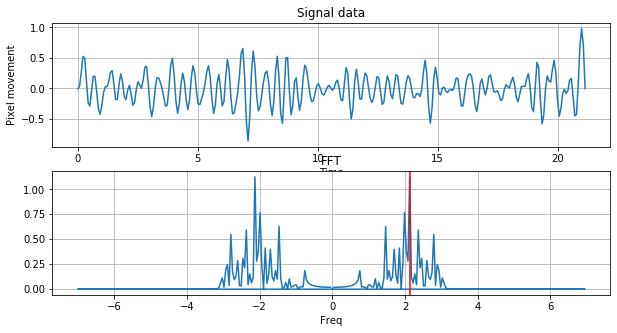

In [157]:
max_ratios = []
max_freqs = []
for i, signal_data in enumerate(pca_result):
    maxFreq, percentage = get_results(signal_data, fs=fps, draw=False)
    
    max_ratios.append(percentage)
    max_freqs.append(maxFreq)

# Find most sure freq out of pcas
idx = np.argmax(max_ratios)
last_pca = pca_result[idx]

print('BPM', max_freqs[idx]*60)

get_results(last_pca, fs=fps, draw=True)


In [148]:
max_freqs

[1.3243243243243243,
 2.506756756756757,
 1.5135135135135136,
 2.506756756756757,
 2.1283783783783785]

In [149]:
idx

0

Max power Freq 4.5608108108108105 % 0.05817450809838211 BPM:128.57142857142856


(4.5608108108108105, 0.05817450809838211)

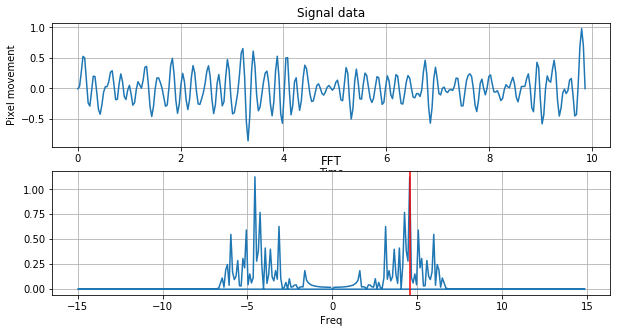

In [152]:
get_results(pca_result[0], draw=True)